# Texto y Anotaciones en las gráficas

Crear una buena visualización implica guiar al lector a través de la figura para contarle una historia.
En algunos casos, esta historia se puede contar de una manera completamente visual, sin la necesidad de agregar texto, pero en otros, son necesarias pequeñas señales textuales (y etiquetas).

Hasta ahora, a excepción de la función ``plt.text()``, lo único que hemos visto para añadir texto a nuestras figuras son los tipos más básicos de anotaciones, que son ejes y títulos. Sin embargo, las opciones van más allá.

En este notebook vamos a ver cómo podemos añadir ciertas anotaciones en nuestras gráficas para aportar más información. Comenzaremos configurando el notebook para representar e importar las funciones que usaremos:

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd

## Ejemplo: Efecto de las vacaciones en los nacimientos en USA

Para el siguiente ejemplo, utilizaremos el dataset de nacimientos de USA, que lo hemos visto en el ejemplo de las pivot tables. En este caso, lo utilizaremos para visualizar las medias de nacimientos por día del año, a lo largo de varios años.

Para ello comenzaremos limpiando un poco el dataset, que ya habíamos visto el otro día que había algunos días que no eran coherentes:

In [20]:
births = pd.read_csv('births.csv').dropna()

# Limpiamos los datos, quedándonos con aquellas combinaciones de día/mes válidas:
cond1 = births['month'].apply(lambda x: x in [1, 3, 5, 7, 8, 10, 12]) & (births['day'].apply(lambda x: 1 <= x <= 31))
cond2 = births['month'].apply(lambda x: x in [4, 6, 9, 11]) & (births['day'].apply(lambda x: 1 <= x <= 30))
cond3 = births['month'].apply(lambda x: x == 2) & (births[['day', 'year']].apply(lambda x: 1 <= x[0] <= 28+(x[1]%4==0), axis=1))
cond_total = cond1 | cond2 | cond3
births = births[cond_total]

In [21]:
births.dtypes

year        int64
month       int64
day       float64
gender     object
births      int64
dtype: object

In [22]:
# Convertimos los días a enteros:
births['day'] = births['day'].astype(int)

# Nos creamos la pivot table y modificamos los índices para que se interpreten con formato de fecha gracias a la función pd.to_datetime (deprecated), 
#en lo que profundizaremos cuando empecemos con feature engineering:
births.index = pd.to_datetime(10000 * births.year + 100 * births.month + births.day, format='%Y%m%d')

births_by_date = births.pivot_table('births', [births.index.month, births.index.day])

# En este caso, hacemos un apaño: necesitamos poner un año aunque sea el agregado de varios años, simplemente para que nos reconozca el formato fecha:
births_by_date.index = [pd.datetime(2000, month, day) for (month, day) in births_by_date.index]

<ipython-input-22-05069add484f>:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  births_by_date.index = [pd.datetime(2000, month, day) for (month, day) in births_by_date.index]


In [23]:
births_by_date.shape

(366, 1)

Cuando comunicamos datos como este, a menudo es útil anotar ciertas características de la visualización para captar la atención del lector.
Esto se puede hacer manualmente con el comando `` plt.text `` (o su equivalente orientada a objetos `` ax.text ``), que colocará el texto en unos valores (X, Y) particulares:

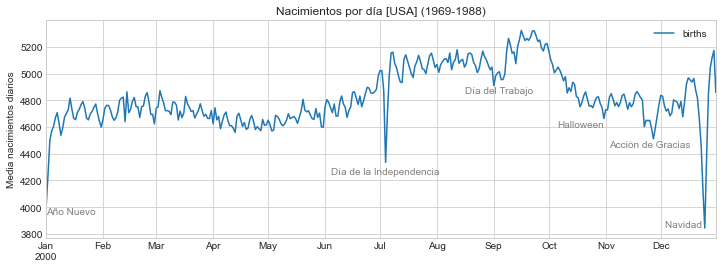

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax)

# Parámetros comunes a los textos:
style = dict(size=10, color='gray')

# Ahora estamos poniendo el mismo eje X que hemos utilizado antes, así que seguirá con la referencia del año 2000:
ax.text('2000-01-01', 3950, "Año Nuevo", **style)
ax.text('2000-07-04', 4250, "Día de la Independencia", ha='center', **style)
ax.text('2000-09-04', 4850, "Día del Trabajo", ha='center', **style)
ax.text('2000-10-31', 4600, "Halloween", ha='right', **style)
ax.text('2000-11-25', 4450, "Acción de Gracias", ha='center', **style)
ax.text('2000-12-25', 3850, "Navidad ", ha='right', **style)

# Etiquetas de los ejes:
ax.set(title='Nacimientos por día [USA] (1969-1988)',
       ylabel='Media nacimientos diarios');

# # Para poner los nombres de los meses centrados
# ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
# ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=15))
# ax.xaxis.set_major_formatter(plt.NullFormatter())
# ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%h'));

El método ``ax.text`` toma una posición X, una posición Y, un string, y luego keywords opcionales con los que podemos especificar el color, tamaño, estilo, alineación y otras propiedades del texto.

En este caso, usamos `` ha = 'right' `` y `` ha = 'center' ``, donde `` ha `` es la abreviatura de *horizonal alignment* (alineación horizontal).
No entraremos en detalle, pero si queremos algo más, podemos consultar las diferentes posibilidades de `` plt.text () `` y `` mpl.text.Text () `` mediante su documentación.

## Transforms y Posiciones del Texto

En el ejemplo anterior, hemos puesto nuestras anotaciones de texto en función de las posiciones de los datos. A veces, es preferible establecer el texto en relación a la posición en los ejes o la figura, independientemente de los datos. En Matplotlib, esto se mediante *transform*.

Cualquier framework de visualización de gráficos necesita algún esquema para traducir entre sistemas de coordenadas.
Por ejemplo, un punto de datos en $(x, y) = (1, 1)$ debe representarse de alguna manera en una determinada ubicación de la figura, que a su vez debe representarse en píxeles en la pantalla.
Matemáticamente, estas transformaciones de coordenadas son relativamente sencillas, y Matplotlib tiene un conjunto bien desarrollado de herramientas que utiliza internamente para realizarlas (estas herramientas se pueden explorar en el submódulo `` matplotlib.transforms``).

El usuario promedio rara vez necesita preocuparse por los detalles de estas transformaciones, pero es útil tener cierto conocimiento al considerar la ubicación del texto en una figura. Hay tres transformaciones predefinidas que nos pueden resultar útiles:

- ``ax.transData``: Transform asociado con las coordenadas de los datos
- ``ax.transAxes``: Transform asociado con los ejes (en sus mismas unidades)
- ``fig.transFigure``: Transform asociado a la figura (con las unidades de la figura)

A continuación, ponemos esto en práctica con un ejemplo de cómo dibujar texto en varias ubicaciones:

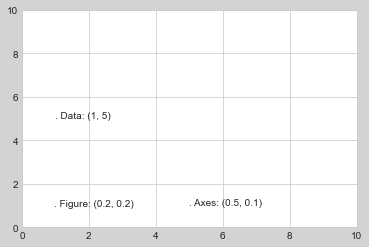

In [25]:
fig, ax = plt.subplots(facecolor='lightgray')
ax.axis([0, 10, 0, 10])

ax.text(1, 5, ". Data: (1, 5)", transform=ax.transData)
ax.text(0.5, 0.1, ". Axes: (0.5, 0.1)", transform=ax.transAxes)
fig.text(0.2, 0.2, ". Figure: (0.2, 0.2)", transform=fig.transFigure);

Fíjate que, de forma predeterminada, el texto se alinea encima y a la izquierda de las coordenadas especificadas: aquí el "." al comienzo de cada string marcará aproximadamente la ubicación de coordenadas dada.

Las coordenadas de `` transData `` dan las coordenadas de datos habituales asociadas a las etiquetas de los ejes X e Y.
Las coordenadas de `` transAxes `` dan la ubicación desde la esquina inferior izquierda de los ejes (el cuadro blanco), como una fracción del tamaño de los mismos.
Las coordenadas de `` transFigure `` son similares, pero especifican la posición desde la parte inferior izquierda de la figura (el cuadro gris), como una fracción del tamaño de la figura.

Fíjate además que, si cambiamos los límites de los ejes, solo se verán afectadas las coordenadas `` transData ``, mientras que las demás permanecen estacionarias:

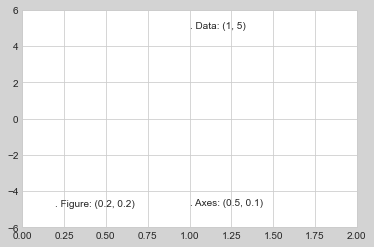

In [26]:
ax.set_xlim(0, 2)
ax.set_ylim(-6, 6)
fig

Si queremos ver un ejemplo donde cambien las referentes a la figura y a los ejes, podríamos utilizar un subplot:

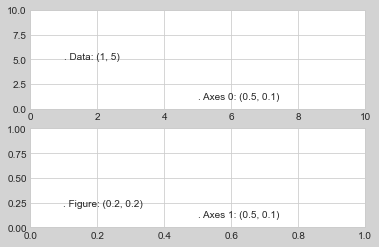

In [27]:
fig, ax = plt.subplots(2, facecolor='lightgray')
ax[0].axis([0, 10, 0, 10])

ax[0].text(1, 5, ". Data: (1, 5)", transform=ax[0].transData)
ax[0].text(0.5, 0.1, ". Axes 0: (0.5, 0.1)", transform=ax[0].transAxes)
ax[1].text(0.5, 0.1, ". Axes 1: (0.5, 0.1)", transform=ax[1].transAxes)
# # OJO, para poder verlo, tendremos que hacer referencia al eje donde caería el punto respecto a la figura. Si no, no lo veremos:
# ax[0].text(0.2, 0.2, ". Figure: (0.2, 0.2)", transform=fig.transFigure)
ax[1].text(0.2, 0.2, ". Figure: (0.2, 0.2)", transform=fig.transFigure);
# # O podríamos poner directamente la figura:
# fig.text(0.2, 0.2, ". Figure: (0.2, 0.2)", transform=fig.transFigure);

## Flechas y anotaciones

Junto con las marcas de los ejes y el texto, otra anotación útil es la flecha simple.

Dibujar flechas en Matplotlib a menudo es mucho más difícil de lo que podríamos imaginarnos en primera instancia.
Si bien hay una función `` plt.arrow () `` disponible, puede que no sea lo más adecuado, pues las flechas que crea son objetos SVG que estarán sujetos a la relación de aspecto variable de sus gráficos, y el resultado rara vez es lo que podemos haber ideado.
En cambio, sí que resulta más sencillo utilizar la función `` plt.annotate () ``, que nos permitirá crear texto y una flecha, que se podrá especificar de manera muy flexible.

A continuación, veremos `` annotate `` con varias de sus opciones:

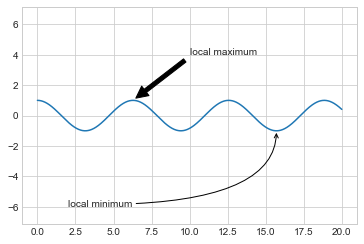

In [28]:
%matplotlib inline

fig, ax = plt.subplots()

x = np.linspace(0, 20, 1000)
ax.plot(x, np.cos(x))
ax.axis('equal') # esto es importante

ax.annotate('local maximum', xy=(6.28, 1), xytext=(10, 4),
            arrowprops=dict(facecolor='black', shrink=0.05))

ax.annotate('local minimum', xy=(5 * np.pi, -1), xytext=(2, -6),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"));

El estilo de flecha lo podemos controlar a través del diccionario `` arrowprops ``, que tiene numerosas opciones disponibles.
Si consultamos la documentación de Matplotlib, veremos que son muchas opciones, pero que, al igual que los métodos que hemos ido viendo, están extensamente documentadas. Por lo tanto, aquí veremos algunos ejemplos, pero si queremos hacer algo en concreto, tendremos que recurrir a la [documentación](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.axes.Axes.annotate.html).

Para estos ejemplos, seguiremos usando el dataset de nacimientos en los Estados Unidos:

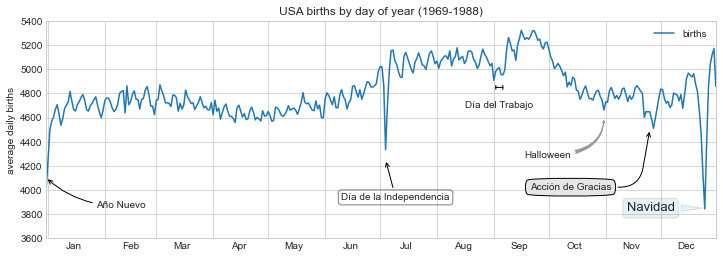

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax)

# Etiquetas de los plots
ax.annotate("Año Nuevo", xy=('2000-01-01', 4100),  xycoords='data',
            xytext=(50, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2"))

ax.annotate("Día de la Independencia", xy=('2000-07-04', 4250),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(10, -40), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax.annotate('Día del Trabajo', xy=('2000-09-04', 4850), xycoords='data', ha='center',
            xytext=(0, -20), textcoords='offset points')
# Complemento para poner un "ranguito" que complemente el Día del Trabajo
ax.annotate('', xy=('2000-09-01', 4850), xytext=('2000-09-07', 4850),
            xycoords='data', textcoords='data',
            arrowprops={'arrowstyle': '|-|,widthA=0.2,widthB=0.2', })

ax.annotate('Halloween', xy=('2000-10-31', 4600),  xycoords='data',
            xytext=(-80, -40), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('Acción de Gracias', xy=('2000-11-25', 4500),  xycoords='data',
            xytext=(-120, -60), textcoords='offset points',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))


ax.annotate('Navidad', xy=('2000-12-25', 3850),  xycoords='data',
             xytext=(-30, 0), textcoords='offset points',
             size=13, ha='right', va="center",
             bbox=dict(boxstyle="round", alpha=0.1),
             arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1));

# Etiquetas generales:
ax.set(title='USA births by day of year (1969-1988)',
       ylabel='average daily births')

# Al igual que antes, centramos los meses
ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%h'));

ax.set_ylim(3600, 5400);

Como puedes ver, las especificaciones de las flechas y los cuadros de texto son muy detalladas, lo que puede ser visto como que es algo que nos da el poder de crear casi cualquier estilo de flecha que deseemos. Sin embargo, por otra parte, también puede ser visto como algo que añada una gran complejidad debido a tener que manejar tantos parámetros que deben ajustarse manualmente, un proceso que puede llevar mucho tiempo cuando se producen gráficos para algún tipo de publicación.

Finalmente, se hace necesario remarcar que las combinaciones de estilos del ejemplo anterior no es de ninguna manera la mejor práctica para presentar datos, sino que se incluye como una demostración de algunas de las opciones disponibles.

Si quieres seguir profundizando sobre ello, tienes ejemplos como [este](http://matplotlib.org/examples/pylab_examples/annotation_demo2.html) en la documentación de Matplotlib.

# Personalizando las marcas de los ejes

Los localizadores y formateadores de ticks predeterminados de Matplotlib están diseñados para ser suficientes en la mayoría de situaciones comunes, pero debido a la variedad que pueden presentar los datos, evidentemente, no son óptimos para todos los gráficos. En esta sección mostraremos varios ejemplos de cómo ajustar las posiciones de las marcas y su formato en función del tipo de gráfico que nos interese.

No obstante, antes de entrar en ejemplos, será mejor para nosotros comprender la jerarquía de objetos de los gráficos de Matplotlib.
Matplotlib tiene como objetivo tener un objeto Python que represente todo lo que aparece en la visualización: por ejemplo, la `` figure `` es el cuadro delimitador dentro del cual aparecen los elementos de la visualización.

Cada objeto Matplotlib también puede actuar como un contenedor de subobjetos: por ejemplo, cada `` figure `` puede contener uno o más objetos de `` axes ``, cada uno de los cuales a su vez contiene otros objetos que representan el contenido de la visualización.

Las marcas de los ejes no son una excepción. Cada `` axes `` tiene atributos `` xaxis `` e `` yaxis ``, que, a su vez, tienen atributos que contienen todas las propiedades de las líneas, ticks y etiquetas que componen los ejes.

## Marcas mayores y menores

Dentro de cada eje, existe el concepto de marca mayor y marca menor. Como se puede extraer de los propios nombres, los ticks (marquitas de los ejes) principales suelen ser más grandes o más pronunciados, mientras que los ticks menores suelen ser más pequeños.

Matplotlib no suele utilizar ticks menores por defecto, pero en casos particulares, como pueden ser los gráficos logarítmicos, sí que se ponen de manifiesto.

In [30]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np

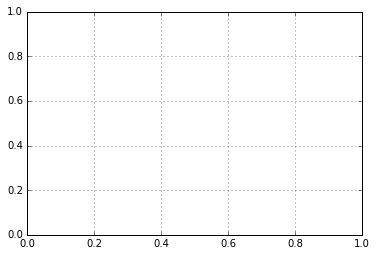

In [31]:
# Escala lineal: solo marcas mayores
ax = plt.axes()
ax.grid();

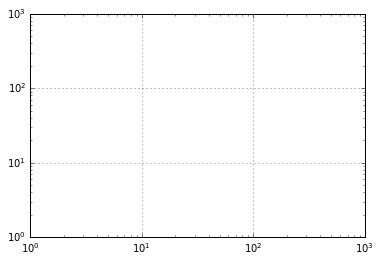

In [32]:
# Escala logarítmica: marcas mayores y menores
ax = plt.axes(xscale='log', yscale='log')
ax.set_xlim(1, 1000)
ax.set_ylim(1, 1000)
ax.grid();

Aqui vemos que cada tick principal muestra una marca grande y una etiqueta, mientras que cada tick menor muestra una marca más pequeña sin etiqueta.

Estas propiedades de los ticks (ubicaciones y etiquetas) se pueden personalizar configurando los objetos de `` formatter `` y `` locator `` de cada eje. Apliquemos estos para el eje X del gráfico que acabamos de mostrar:

In [33]:
print(ax.xaxis.get_major_locator())
print(ax.xaxis.get_minor_locator())

In [34]:
print(ax.xaxis.get_major_formatter())
print(ax.xaxis.get_minor_formatter())

Ceamos algunos ejemplos en los que establezcamos los valores de los ``locators`` y los ``formatters`` en varias gráficas:

## Ocultando Ticks y Etiquetas

Quizás de formateo de ticks/etiquetas más común es ocultar estos ticks/etiquetas, lo cual podmeos hacer usando `` plt.NullLocator() `` y `` plt.NullFormatter() ``, como se muestra a continuación:

In [35]:
data = np.random.rand(50)

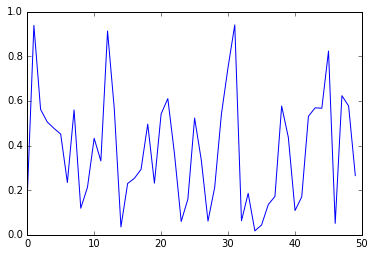

In [36]:
# Normal:
ax = plt.axes()
ax.plot(data);

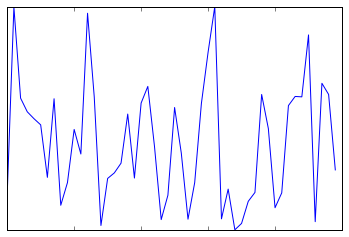

In [37]:
# Formateada:
ax = plt.axes()
ax.plot(data)

ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_formatter(plt.NullFormatter());

Fíjate que hemos eliminado las etiquetas (pero hemos mantenido las marquitas) del eje X, y hemos eliminado las marcas (y por lo tanto las etiquetas también) del eje Y.

No tener ningún tipo de marcas puede ser útil en muchas situaciones, por ejemplo, cuando queramos mostrar una cuadrícula de imágenes, como la siguiente:

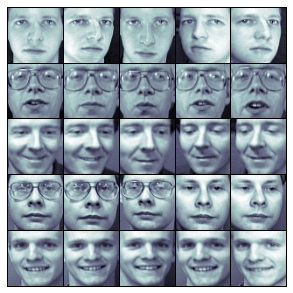

In [38]:
fig, ax = plt.subplots(5, 5, figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

# Leemos un set de imágenes de caras de sklearn:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces().images

for i in range(5):
    for j in range(5):
        ax[i, j].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j].yaxis.set_major_locator(plt.NullLocator())
        ax[i, j].imshow(faces[10 *i + j], cmap="bone")

Como podemos comprobar, cada imagen tiene sus propios ejes, pero hemos establecido los ``locator`` como nulos para que los valores de los ticks (número de píxel en este caso) no den esa información, ya que no es relevante para esta visualización en particular.

## Reduciendo o aumentando el número de Ticks

Un problema común con la configuración predeterminada es que las subgráficas más pequeñas pueden terminar con etiquetas que nos llenen todo el eje:

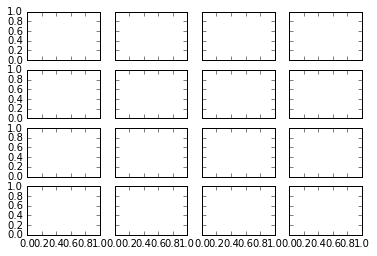

In [39]:
fig, ax = plt.subplots(4, 4, sharex=True, sharey=True)

Particularmente para los ticks del eje X, los números casi se superponen y los hacen bastante difíciles de leer.
Podemos solucionar esto con `` plt.MaxNLocator() ``, que nos permite especificar el número máximo de ticks que se mostrarán en ambos ejes.
Dado un número máximo, Matplotlib utilizará la lógica interna para elegir las ubicaciones particulares de los ticks:

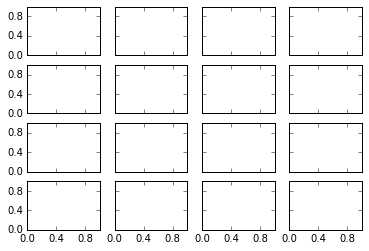

In [40]:
# Lo configuramos en X e Y, para cada eje:
for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(3))
    axi.yaxis.set_major_locator(plt.MaxNLocator(3))
fig

Esto hace que las cosas sean mucho más limpias y bonitas. Si queremos aún más control sobre las ubicaciones de los ticks equiespaciados, podemos usar ``plt.MultipleLocator``, tal y como se muestra en la siguiente sección.

## Formatos misceláneos para los Ticks

El formato predeterminado de Matplotlib para los tick puede dejar mucho que desear: generaliza bien, pero a veces se nos queda muy corto.

Veamos qué podemos hacer partiendo de la sigueitne visualización de un seno y un coseno:

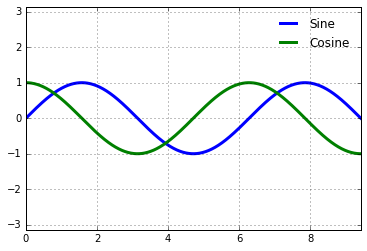

In [41]:
# Plot a sine and cosine curve
fig, ax = plt.subplots()
x = np.linspace(0, 3 * np.pi, 1000)
ax.plot(x, np.sin(x), lw=3, label='Sine')
ax.plot(x, np.cos(x), lw=3, label='Cosine')

# Set up grid, legend, and limits
ax.grid(True)
ax.legend(frameon=False)
ax.axis('equal')
ax.set_xlim(0, 3 * np.pi);

Se nos ocurren un par de cambios que nos gustaría hacer. Primero, es más natural para estos datos espaciar las marcas y las líneas de la cuadrícula en múltiplos de $\pi$ (ya que marca la periodicidad de ambas funcinoes). Podemos hacer esto configurando un `` MultipleLocator ``, que ubica los ticks en un múltiplo del número que le pasemos como argumento.

Para ello, agregaremos ticks mayores y menores en múltiplos de $\pi / 2$ y $\pi / 4$, respectivamente:

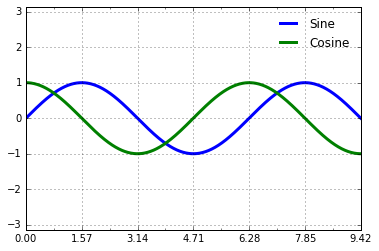

In [42]:
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
fig

Pero ahora las etiquetas de los ticks resultan un poco raras, ya que podemos ver que son múltiplos de $ \pi $, pero la representación decimal nos hace dudar sobre lo que estamos viendo.

Para solucionar esto, podemos cambiar el ``foramtter`` de ticks. No hay un ``formatter`` incorporado para lo que queremos hacer, por lo que usaremos ``plt.FuncFormatter``, que acepta una función definida por el usuario que brinda un control detallado sobre las salidas de tick:

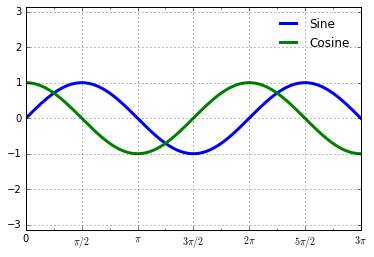

In [43]:
def format_func(value, tick_number):
    # find number of multiples of pi/2
    N = int(np.round(2 * value / np.pi))
    if N == 0:
        return "0"
    elif N == 1:
        return r"$\pi/2$"
    elif N == 2:
        return r"$\pi$"
    elif N % 2 > 0:
        return r"${0}\pi/2$".format(N)
    else:
        return r"${0}\pi$".format(N // 2)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
fig

Fíjate que hemos hecho uso del soporte LaTeX de Matplotlib, especificado al meter el string entre signos de dólar. Esto es muy conveniente para la visualización de fórmulas y símbolos matemáticos: en este caso, `` "$\pi$" `` se representa como el carácter griego $ \pi $.

El `` plt.FuncFormatter () `` ofrece un control extremadamente detallado sobre la apariencia de los ticks de la gráfica, lo cuál es muy útil para crear nuestras visualizaciones para eventos o publicaciones.

## Resumen de Formatters y Locators


A lo largo del notebook se ha mencionado algún que otro ``formatter`` o ``locator``, pero no hemos podido ver todos. A continuación, se recogen un par de tablas resumen que describen brevemente todas las opciones de ``formatters`` y ``locators`` extraídas directamente de la documentación (en inglés), la cual convendría que consultaras para echarle un vistazo a lo que quieres realizar:

Locator class        | Description
---------------------|-------------
``NullLocator``      | No ticks
``FixedLocator``     | Tick locations are fixed
``IndexLocator``     | Locator for index plots (e.g., where x = range(len(y)))
``LinearLocator``    | Evenly spaced ticks from min to max
``LogLocator``       | Logarithmically ticks from min to max
``MultipleLocator``  | Ticks and range are a multiple of base
``MaxNLocator``      | Finds up to a max number of ticks at nice locations
``AutoLocator``      | (Default.) MaxNLocator with simple defaults.
``AutoMinorLocator`` | Locator for minor ticks

Formatter Class       | Description
----------------------|---------------
``NullFormatter``     | No labels on the ticks
``IndexFormatter``    | Set the strings from a list of labels
``FixedFormatter``    | Set the strings manually for the labels
``FuncFormatter``     | User-defined function sets the labels
``FormatStrFormatter``| Use a format string for each value
``ScalarFormatter``   | (Default.) Formatter for scalar values
``LogFormatter``      | Default formatter for log axes




## Ejercicio

Vamos a aplicar alguno de estos conceptos:
1. Lee el dataset de los futbolistas y limpia los nulos
2. Quédate con los zurdos ('preferred_foot' = 'Left') con un 'overall' mayor que 80 y ordénalos por nombre
3. Representa el 'overall' (eje Y) en base al nombre (eje X)
4. Como los ticks del eje X y sus etiquetas se ven muy mal, elimínalas
5. Identifica los 3 futbolistas con mayor 'overall' y pon su nombre sobre la gráfica. Los nombres deberán de estar centrados salvo que no entren por estar cerca de un extremo, en cuyo caso tendrás que ponerlos como 'right' o 'left'. Si el nombre sobrepasa por arriba, modifica la gráfica para que entre bien
6. A partir de la anterior, pon una separación entre el nombre del jugador y el punto en cuestión. Además, añádele un marco a cada uno de ellos de color amarillo, gris y naranja, en función de su posición en nuestro ranking de 'overall'
7. Modifica la gráfica anterior para identificar cada futbolista con una flecha. Las 3 flechas deberán ser diferentes, por ejemplo: simple, curva y *fancy*

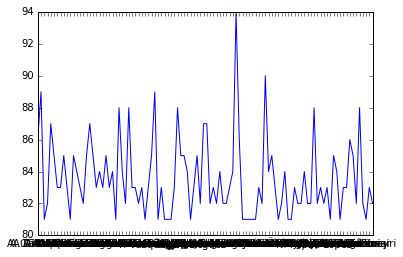

In [44]:
df = pd.read_csv("FIFA20.csv")

df2 = df.copy().dropna()
df2 = df2[(df2['overall']>80) & (df2['preferred_foot']=='Left')]
df2 = df2.sort_values(by='short_name')
plt.plot(df2['short_name'], df2['overall']);

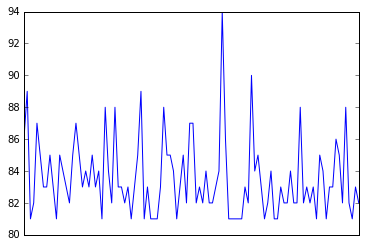

In [45]:
fig, ax = plt.subplots()

ax.plot(df2['short_name'], df2['overall'])
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.xaxis.set_minor_locator(plt.NullLocator());

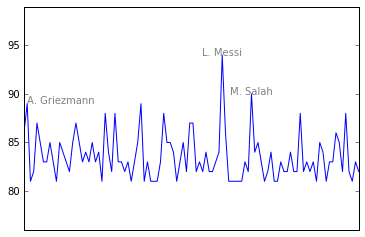

In [46]:
max_players = df2.sort_values(by='overall', ascending=False)[['short_name', 'overall']].iloc[:3]
max_players

style = dict(size=10, color='gray')

# Ahora estamos poniendo el mismo eje X que hemos utilizado antes, así que seguirá con la referencia del año 2000:
ax.text(max_players.iloc[0, 0], max_players.iloc[0, 1], max_players.iloc[0, 0], ha='center', **style)
ax.text(max_players.iloc[1, 0], max_players.iloc[1, 1], max_players.iloc[1, 0], ha='center', **style)
ax.text(max_players.iloc[2, 0], max_players.iloc[2, 1], max_players.iloc[2, 0], ha='left', **style)

ax.set_ylim([min(df2['overall']) -5, max(df2['overall']) +5])

fig

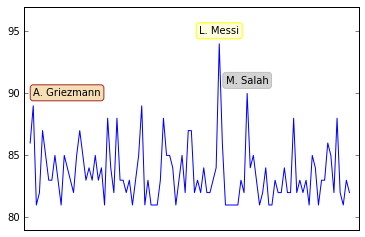

In [47]:
fig, ax = plt.subplots()

ax.plot(df2['short_name'], df2['overall'])

ax.annotate(max_players.iloc[0, 0], xy=(max_players.iloc[0, 0], max_players.iloc[0, 1]),  xycoords='data',
            bbox=dict(boxstyle="round", fc="lightyellow", ec="yellow"),
            xytext=(0, 10), textcoords='offset points', ha='center')

ax.annotate(max_players.iloc[1, 0], xy=(max_players.iloc[1, 0], max_players.iloc[1, 1]),  xycoords='data',
            bbox=dict(boxstyle="round", fc="lightgrey", ec="silver"),
            xytext=(0, 10), textcoords='offset points', ha='center')

ax.annotate(max_players.iloc[2, 0], xy=(max_players.iloc[2, 0], max_players.iloc[2, 1]),  xycoords='data',
            bbox=dict(boxstyle="round", fc="wheat", ec="brown"),
            xytext=(0, 10), textcoords='offset points', ha='left')

ax.set_ylim([min(df2['overall']) -2, max(df2['overall']) +3])
ax.set_xlim([-2, df2.shape[0] +2])

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.xaxis.set_minor_locator(plt.NullLocator());

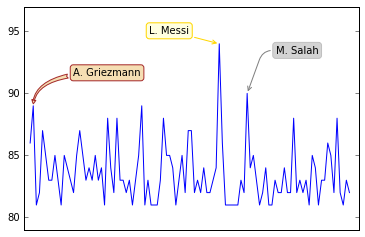

In [51]:
fig, ax = plt.subplots()

ax.plot(df2['short_name'], df2['overall'])

ax.annotate(max_players.iloc[0, 0], xy=(max_players.iloc[0, 0], max_players.iloc[0, 1]),  xycoords='data',
            bbox=dict(boxstyle="round", fc="lightyellow", ec="gold"),
            xytext=(-50, 10), textcoords='offset points', ha='center', 
            arrowprops=dict(arrowstyle="->", ec='gold'))

ax.annotate(max_players.iloc[1, 0], xy=(max_players.iloc[1, 0], max_players.iloc[1, 1]),  xycoords='data',
            bbox=dict(boxstyle="round", fc="lightgrey", ec="silver"),
            xytext=(50, 40), textcoords='offset points', ha='center', 
            arrowprops=dict(arrowstyle="->", ec="grey", connectionstyle="angle,angleA=0,angleB=70,rad=10"))

ax.annotate(max_players.iloc[2, 0], xy=(max_players.iloc[2, 0], max_players.iloc[2, 1]),  xycoords='data',
            bbox=dict(boxstyle="round", fc="wheat", ec="brown"),
            xytext=(40, 30), textcoords='offset points', ha='left', 
            arrowprops=dict(arrowstyle="fancy", fc="wheat", ec="brown", connectionstyle="angle3,angleA=0,angleB=-90"))

ax.set_ylim([min(df2['overall']) -2, max(df2['overall']) +3])
ax.set_xlim([-2, df2.shape[0] +2])

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.xaxis.set_minor_locator(plt.NullLocator());

## Ejercicio

Ahora utilizaremos el dataframe del Titanic:
1. Lee el dataset y limpia los nulos
2. Limpia los datos eliminando los registros de aquellas personas con años decimales y convierte la columna "Age" a entero
3. Crea una columna nueva ("Char_name") que cuente el número de caracteres del nombre, y otra ("Tratamiento") que obtenga el tratamiento que se le debe dar a cada pasajero (es decir, "Mr", "Miss"...)
4. Crea un dataframe para Miss otro para Mr y otro para Miss
5. Agrupa según la edad y calcula la media de "Char_name" por edad para cada DataFrame
6. Representa la media que has calculado para cada DataFrame en la misma gráfica. Añade etiquetas a los ejes, un título y una leyenda. Modifica los ejes para que 

In [495]:
df = pd.read_csv("titanic.csv")
df = df[df['Age'].notnull()]
df = df[df['Age'].apply(lambda x: int(x)==x)]
df['Age'] = df['Age'].astype(int)
df['Char_name'] = df['Name'].str.len()
df['Tratamiento'] = df['Name'].str.split(", ").str.get(1).str.split('.').str.get(0)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Char_name,Tratamiento
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,23,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,51,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,22,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,44,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,24,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39,0,5,382652,29.1250,NaN,Q,36,Mrs
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,NaN,S,21,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S,28,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,C148,C,21,Mr


In [502]:
df[df['Tratamiento'].isin(['Mr', 'Miss', 'Mrs'])]
df1 = df[df['Tratamiento']=='Mr'].groupby(['Age']).agg({'Char_name': 'mean'})
df2 = df[df['Tratamiento']=='Mrs'].groupby(['Age']).agg({'Char_name': 'mean'})
df3 = df[df['Tratamiento']=='Miss'].groupby(['Age']).agg({'Char_name': 'mean'})
df4 = df[~(df['Tratamiento'].isin(['Mr', 'Miss', 'Mrs']))].groupby(['Age']).agg({'Char_name': 'mean'})

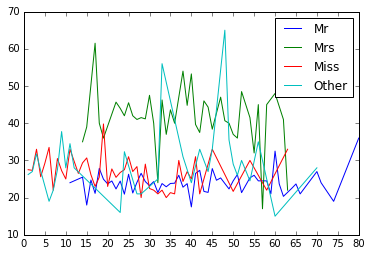

In [504]:
fig, ax = plt.subplots()

ax.plot(df1.index, df1['Char_name'], label="Mr")
ax.plot(df2.index, df2['Char_name'], label="Mrs")
ax.plot(df3.index, df3['Char_name'], label="Miss")
ax.plot(df4.index, df4['Char_name'], label="Other")


ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.xaxis.set_minor_locator(plt.MultipleLocator(5))

ax.legend();